(section-regression-linear)=
# Linear regression

You have probably encountered the most basic form of regression: fitting a straight line to data points $(x_i,y_i)$ in the $xy$-plane. In this we assume a relation

$$
y \approx f(x) = ax + b,
$$

and define a **loss function** or *misfit function* that adds up how far predictions are from the data:

$$
L(a,b) = \sum_{i=1}^n (f(x_i)-y_i)^2 = \sum_{i=1}^n (a x_i+b-y_i)^2.
$$

This problem can be solved by a little multidimensional calculus. If we hold $b$ fixed and take a derivative with respect to $a$, then

$$
\pp{L}{a} = \sum_{i=1}^n 2x_i(a x_i + b - y_i) = 2 a \left(\sum_{i=1}^n x_i^2\right) + 2b\left(\sum_{i=1}^n x_i\right) - 2\sum_{i=1}^n x_i y_i.
$$

Similarly, if we hold $a$ fixed and differentiate with respect to $b$, then 

$$
\pp{L}{b} = \sum_{i=1}^n 2(a x_i + b - y_i) = 2 a \left(\sum_{i=1}^n x_i\right) + 2bn - 2 \sum_{i=1}^n y_i.
$$

Setting both derivatives to zero creates a system of two linear equations to be solved for $a$ and $b$. 

::::{prf:example}
:label: example-linear-fit
Find the linear regressor of the points $(-1,0)$, $(0,2)$, $(1,3)$.

:::{dropdown} Solution
We need a few sums to fill in the system to be solved:

$$
\sum_{i=1}^n x_i^2 = 1+0+1=2, \qquad & \sum_{i=1}^n x_i = -1+0+1=0, \\ 
\sum_{i=1}^n x_iy_i = 0+0+3=3, \qquad & \sum_{i=1}^n y_i = 0+2+3=5. 
$$

Therefore we must solve (note that $n=3$)

$$
2a + 0b &= 3, \\ 
0a + 3b &= 5. 
$$

The regression function is $f(x)=\tfrac{3}{2} x + \tfrac{5}{3}$. 
:::
::::



Before moving on, we adopt a vector-oriented view of the process. As a sum of squares, the loss function can be written as a 2-norm:

$$
L(a,b) =  \twonorm{a\, \bfx + b \,\bfe - \bfy}^2,
$$

where $\bfe$ is a vector of $n$ ones. Minimizing $L$ over all values of $a$ and $b$ is called the **least squares** problem. (More specifically, this setup is called *simple least squares* or *ordinary least squares*.)

## Performance metrics

We need to establish ways to measure regression performance. Unlike with binary classification, in regression it's not just a matter of "right" and "wrong" answers. 

Suppose a regressor trained on $(x_i,y_i)$ for $i=1,\ldots,n$ is represented by the function $f(x)$. We let $(\xi_i,\eta_i)$ for $i=1,\ldots,m$ be the test set, which may be different from the training set. Naturally, we might want to use the differences $y_i-f(x_i)$, which we call **residuals**, and $\eta_i - f(\xi_i)$, which we call **errors**. (The usage of these terms is somewhat variable across different sources, though.)

### MSE

A natural metric is the **mean squared error**,

$$
\frac{1}{m} \sum_{i=1}^m \, \bigl[\eta_i - f(\xi_i)\bigr]^2.
$$

If the training and test sets are the same, then the MSE is proportional to the loss function $L$, which is minimized by the standard regression algorithm. A closely related measure is the **mean absolute error**,

$$
\frac{1}{m} \sum_{i=1}^m \abs{\eta_i - f(\xi_i)},
$$

which is less sensitive to large outlier errors. While easy to understand, these error measurements are dimensional and depend on the scaling of the variables. It might be helpful to compare the MSE to variance of the target values, and MAE to standard deviation.

### Coefficient of determination

The **coefficient of determination** is denoted $R^2$ and defined as

$$
R^2 = 1 - \frac{\displaystyle\sum_{i=1}^m \,\bigl[\eta_i - f(\xi_i)\bigr]^2}{\displaystyle\sum_{i=1}^m \, \bigl(\eta_i - \bar{\eta}\bigr)^2},
$$

where $\bar{\eta}$ is the mean of the target value over the test set. This quantity is dimensionless and therefore independent of scaling. A perfect regressor has an $R^2$ value of 1, while a baseline regressor that always predicts $\bar{\eta}$ would have $R^2=0$. 

An interpretation of the definition in words is that $R^2$ is the fraction of the variance in the true values that is echoed by the variance in the regressor's predictions. When $R^2<1$, we say that the data has *unexplained variance* not accounted for by the regressor.

The notation is potentially confusing, because $R^2$ can actually be negative! Such a result indicates that the predictor $f$ is doing worse than the baseline constant mean-value prediction. However, if $f$ is the result of a standard linear regression, and if the test set is the training set, then $R^2$ equals the square of the Pearson correlation coefficient between the true and predicted values and therefore lies between 0 and 1.

::::{prf:example}
:label: example-linear-CoD
Find the coefficient of determination for the fit in {prf:ref}`example-linear-fit`, if the test set is the same as the training set.

:::{dropdown} Solution
We have $\xi_i=x_i$ and $\eta_i=y_i$ for $i=1,2,3$. We found earlier that $f(x)=\tfrac{3}{2} x + \tfrac{5}{3}$.  Now $\bar{\eta} = \frac{1}{3}(0+2+3)=\frac{5}{3}$, and 

$$
\sum_{i=1}^m \,[\eta_i - f(\xi_i)]^2 &= \left(0-\tfrac{1}{6}\right)^2 + \left(2-\tfrac{5}{3}\right)^2 + \left(3-\tfrac{19}{6}\right)^2 = \frac{1}{6}, \\ 
\sum_{i=1}^m \, [\eta_i - \bar{\eta}]^2 &= \left(0-\tfrac{5}{3}\right)^2 + \left(2-\tfrac{5}{3}\right)^2 + \left(3-\tfrac{5}{3}\right)^2 = \frac{14}{3}. 
$$

This yields $R^2 = 1 - (1/6)(3/14) = 27/28$. 
:::
::::

::::{prf:example}
:label: example-linear-CoDneg
Find the coefficient of determination for the fit $f(x)=x$, if the test set is the same as the training set in {prf:ref}`example-linear-fit`.

:::{dropdown} Solution
The only change from the preceding example is in $f$. 

$$
\sum_{i=1}^m \,[\eta_i - f(\xi_i)]^2 &= \left(0+1\right)^2 + \left(2-0\right)^2 + \left(3-1\right)^2 = 9, \\ 
\sum_{i=1}^m \, [\eta_i - \bar{\eta}]^2 &= \frac{14}{3}. 
$$

This yields $R^2 = 1 - (9)(3/14) = -13/14$. Since the result is negative, we would be better off always predicting $5/3$ instead of $f(x)$. This is possible only because this $f$ is not the least-squares regressor for this dataset.
:::
::::

## Case study: Arctic ice

Let's import data about the extent of sea ice in the Arctic circle, collected monthly since 1979.

In [1]:
import pandas as pd
ice = pd.read_csv("sea-ice.csv")
# Simplify column names:
ice.columns = [s.strip() for s in ice.columns]   
ice

,year,mo,data-type,region,extent,area
0,1979,1,Goddard,N,15.41,12.41
1,1980,1,Goddard,N,14.86,11.94
2,1981,1,Goddard,N,14.91,11.91
3,1982,1,Goddard,N,15.18,12.19
4,1983,1,Goddard,N,14.94,12.01
...,...,...,...,...,...,...
513,2017,12,Goddard,N,11.74,10.26
514,2018,12,Goddard,N,11.86,10.45
515,2019,12,Goddard,N,11.90,10.52
516,2020,12,Goddard,N,11.73,10.16


A quick plot reveals something odd-looking.

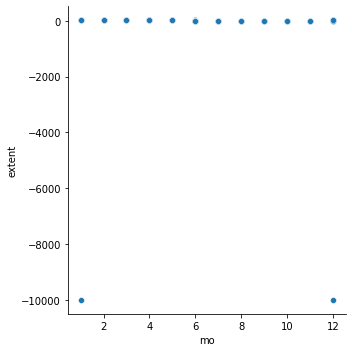

In [2]:
import seaborn as sns
sns.relplot(data=ice,x="mo",y="extent");

Everything in the plot is dominated by two large negative values. These probably represent missing or unreliable data, so we remove those rows.

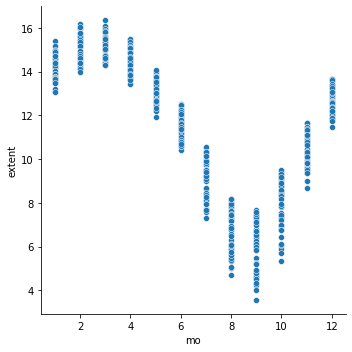

In [3]:
ice = ice[ice["extent"]>0].copy()
sns.relplot(data=ice,x="mo",y="extent");

Each dot represents one measurement. As you would expect, the extent of ice rises in the winter and falls in summer.

In [4]:
bymo = ice.groupby("mo")
bymo["extent"].mean()

mo
1     14.214762
2     15.100233
3     15.256977
4     14.525581
5     13.117442
6     11.539767
7      9.097907
8      6.793256
9      5.993488
10     7.887907
11    10.458182
12    12.664419
Name: extent, dtype: float64

While the effect of the seasonal variation somewhat cancels out over time when fitting a line, it's preferable to remove this obvious trend before the fit takes place. We will add a column that measures the relative change from the mean in each month, i.e., $(x-\bar{x})/\bar{x}$ within each group.

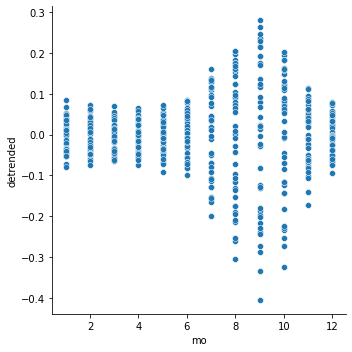

In [5]:
ice["detrended"] = bymo["extent"].transform(lambda x: x/x.mean() - 1)
sns.relplot(data=ice,x="mo",y="detrended")

An `lmplot` in seaborn will show the best-fit line.

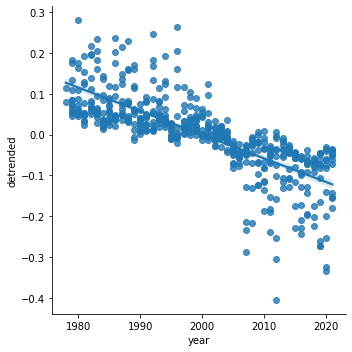

In [6]:
sns.lmplot(data=ice,x="year",y="detrended");

However, keep Simpson's paradox in mind. The previous plot showed considerably more variance in the warm months. How do the fits look for the data *within* each month?

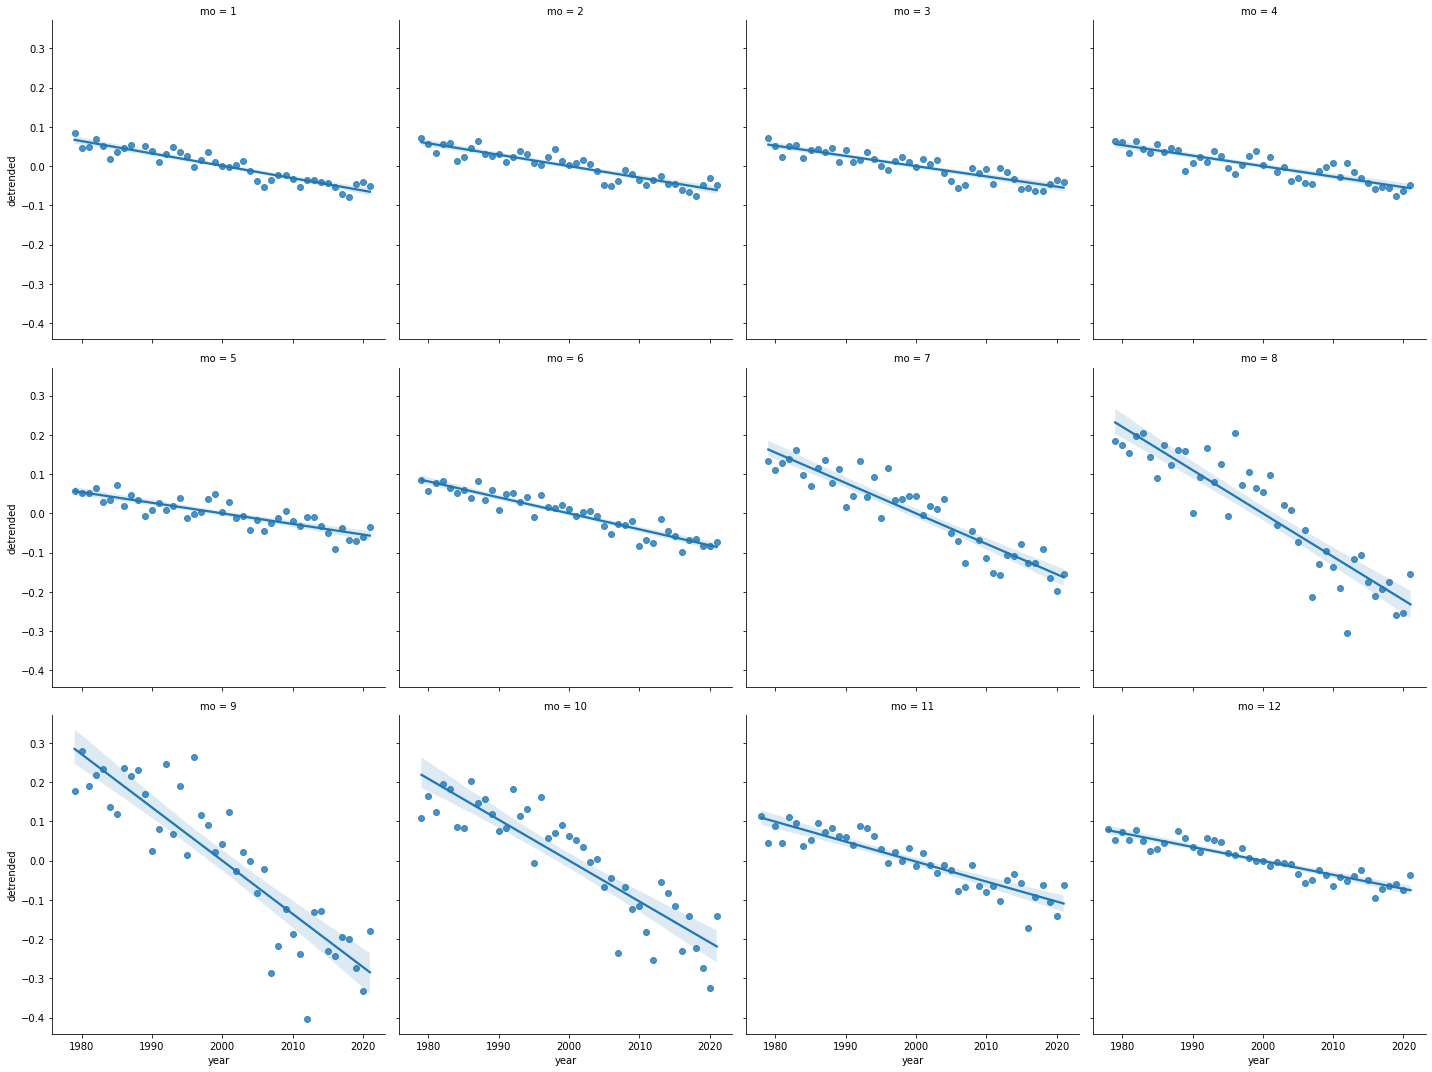

In [7]:
sns.lmplot(data=ice,x="year",y="detrended",col="mo",col_wrap=4);

While the correlation is negative in each month, the effect size is clearly larger in the summer. 

We can get numerical information about a regression line by using a `LinearRegression()` in sklearn. We will focus on the data for August.

In [8]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

aug = ice["mo"]==8
# We need a frame, not a series, so use a vector for columns for X: 
X = ice.loc[aug,["year"]]  
y = ice.loc[aug,"detrended"]
lm.fit(X,y)

LinearRegression()

We can get the slope and $y$-intercept of the regression line from the learner's properties. (Calculated parameters tend to have underscores at the ends of their names in sklearn.)

In [9]:
(lm.coef_,lm.intercept_)

(array([-0.01103658]), 22.07316493030779)

The slope indicates average decrease over time. Here, we assess the performance on the training set. Both the MSE and mean absolute error are small relative to dispersion within the values themselves:

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = lm.predict(X)
mse = mean_squared_error(y,yhat)
mae = mean_absolute_error(y,yhat)

print(f"MSE: {mse:.2e}, compared to variance {y.var():.2e}")
print(f"MAE: {mae:.2e}, compared to standard deviation {y.std():.2e}")

MSE: 4.01e-03, compared to variance 2.33e-02
MAE: 4.93e-02, compared to standard deviation 1.53e-01


The `score` method of the regressor object computes the coefficient of determination:

In [11]:
R2 = lm.score(X,y)
print("R-squared:",R2)

R-squared: 0.8237357450183896


An $R^2$ value this close to 1 would usually be considered a sign of a good fit, although we have not tested for generalization to new data.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_ni5ejhzh&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_sztzkr5t" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>